In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error, auc, roc_curve
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier # Import Random Forest Classifier
from xgboost import XGBClassifier # Import XGBoost Classifier
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn import tree
import statsmodels.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import math
import xlrd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
def load_dataset(filename):
  df = pd.read_csv(filename)
  df.drop(['Unnamed: 0'], axis=1, inplace=True)
  return df

def bin_age(df):
  # Splitting the Age and Years Employed into categories
  df.loc[(df['YEARS_BIRTH'] < 25), 'Age_Category'] = 'Below 25'
  df.loc[(df['YEARS_BIRTH'] <= 35) & (df['YEARS_BIRTH'] >= 25), 'Age_Category'] = '25 to 35'
  df.loc[(df['YEARS_BIRTH'] <= 45) & (df['YEARS_BIRTH'] >= 36), 'Age_Category'] = '36 to 45'
  df.loc[(df['YEARS_BIRTH'] <= 55) & (df['YEARS_BIRTH'] >= 46), 'Age_Category'] = '46 to 55'
  df.loc[(df['YEARS_BIRTH'] > 55), 'Age_Category'] = 'Above 55'
  return df

def bin_years_employed(df):
  df.loc[df['YEARS_EMPLOYED'] == 0, 'Employment'] = 'Unemployed'
  df.loc[(df['YEARS_EMPLOYED'] > 0) & (df['YEARS_EMPLOYED'] <= 10), 'Employment'] = '10 or Less'
  df.loc[(df['YEARS_EMPLOYED'] > 10) & (df['YEARS_EMPLOYED'] <= 20), 'Employment'] = '10 - 20'
  df.loc[(df['YEARS_EMPLOYED'] > 20) & (df['YEARS_EMPLOYED'] <= 30), 'Employment'] = '20 - 30'
  df.loc[(df['YEARS_EMPLOYED'] > 30), 'Employment'] = 'More than 30'
  return df

def bin_income(df):
  df['AMT_INCOME_TOTAL'] = df['AMT_INCOME_TOTAL']*100000
  # Splitting Total Income into bins of $50,000
  df['AMT_INCOME_TOTAL'] = pd.cut(df.AMT_INCOME_TOTAL, bins= [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 1.170000e+08], 
                                  labels= ["0-50k", "50-100k", "100-150k", "150-200k", "200-250k", "250-300k", "300-350k", "Above 350k"])
  return df

def bin_credit(df):
  # Splitting Loan Amounts into bins of $100,000
  df['Credit_Category'] = pd.cut(df.AMT_CREDIT, bins= [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 4.050000e+06], 
                                 labels= ["0-100k", "100-200k", "200-300k", "300-400k", "400-500k", "500-600k", "600-700k", "700-800k", "800-900k","900-1 million", "Above 1 million"])
  return df

def bin_annuity(df):
  # Splitting Annuity into categories
  df.loc[df['AMT_ANNUITY'] < 16524, 'Loan_Annuity'] = 'Low Annuity'
  df.loc[df['AMT_ANNUITY'] > 34596, 'Loan_Annuity'] = 'High Annuity'
  df.loc[(df['AMT_ANNUITY'] >= 16524) & (df['AMT_ANNUITY'] <= 34596), 'Loan_Annuity'] = 'Medium Annuity'
  return df

def binning(df):
  df = bin_annuity(bin_credit(bin_income(bin_years_employed(bin_age(df)))))
  return df

In [ ]:
df = load_dataset("new_df_test.csv")
df = binning(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   TARGET                       307511 non-null  int64   
 1   NAME_CONTRACT_TYPE           307511 non-null  int64   
 2   CODE_GENDER                  307511 non-null  int64   
 3   FLAG_OWN_CAR                 307511 non-null  int64   
 4   FLAG_OWN_REALTY              307511 non-null  int64   
 5   CNT_CHILDREN                 307511 non-null  int64   
 6   AMT_INCOME_TOTAL             307511 non-null  category
 7   AMT_CREDIT                   307511 non-null  float64 
 8   AMT_ANNUITY                  307511 non-null  float64 
 9   NAME_INCOME_TYPE             307511 non-null  int64   
 10  NAME_EDUCATION_TYPE          307511 non-null  int64   
 11  NAME_FAMILY_STATUS           307511 non-null  int64   
 12  NAME_HOUSING_TYPE            307511 non-null

# **Tabulating Credit Score**

In [ ]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,YEARS_BIRTH,YEARS_EMPLOYED,Age_Category,Employment,Credit_Category,Loan_Annuity
0,1,0,1,0,1,0,200-250k,406597.5,24700.5,7,4,3,1,-3648.0,-2120,1,1,0,1,1,0,2,6,10,0,0,0,0,5,0.262949,-1134.0,1,26,2,25 to 35,10 or Less,400-500k,Medium Annuity
1,0,0,0,0,0,0,250-300k,1293502.5,35698.5,4,1,1,1,-1186.0,-291,1,1,0,1,1,0,1,1,11,0,0,0,0,39,0.622246,-828.0,1,46,3,46 to 55,10 or Less,Above 1 million,High Annuity
2,0,1,1,1,1,0,50-100k,135000.0,6750.0,7,4,3,1,-4260.0,-2531,1,1,1,1,1,0,2,1,9,0,0,0,0,11,0.555912,-815.0,0,52,1,46 to 55,10 or Less,100-200k,Low Annuity
3,0,0,0,0,1,0,100-150k,312682.5,29686.5,7,4,0,1,-9833.0,-2437,1,1,0,1,0,0,2,6,17,0,0,0,0,5,0.650442,-617.0,1,52,8,46 to 55,10 or Less,300-400k,Medium Annuity
4,0,0,1,0,1,0,100-150k,513000.0,21865.5,7,4,3,1,-4311.0,-3458,1,1,0,1,0,0,2,4,11,0,0,0,1,37,0.322738,-1106.0,0,55,8,46 to 55,10 or Less,500-600k,Medium Annuity


In [ ]:
df

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,YEARS_BIRTH,YEARS_EMPLOYED,Age_Category,Employment,Credit_Category,Loan_Annuity
0,1,0,1,0,1,0,200-250k,406597.5,24700.5,7,4,3,1,-3648.0,-2120,1,1,0,1,1,0,2,6,10,0,0,0,0,5,0.262949,-1134.0,1,26,2,25 to 35,10 or Less,400-500k,Medium Annuity
1,0,0,0,0,0,0,250-300k,1293502.5,35698.5,4,1,1,1,-1186.0,-291,1,1,0,1,1,0,1,1,11,0,0,0,0,39,0.622246,-828.0,1,46,3,46 to 55,10 or Less,Above 1 million,High Annuity
2,0,1,1,1,1,0,50-100k,135000.0,6750.0,7,4,3,1,-4260.0,-2531,1,1,1,1,1,0,2,1,9,0,0,0,0,11,0.555912,-815.0,0,52,1,46 to 55,10 or Less,100-200k,Low Annuity
3,0,0,0,0,1,0,100-150k,312682.5,29686.5,7,4,0,1,-9833.0,-2437,1,1,0,1,0,0,2,6,17,0,0,0,0,5,0.650442,-617.0,1,52,8,46 to 55,10 or Less,300-400k,Medium Annuity
4,0,0,1,0,1,0,100-150k,513000.0,21865.5,7,4,3,1,-4311.0,-3458,1,1,0,1,0,0,2,4,11,0,0,0,1,37,0.322738,-1106.0,0,55,8,46 to 55,10 or Less,500-600k,Medium Annuity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,1,0,0,0,150-200k,254700.0,27558.0,7,4,2,5,-8456.0,-1982,1,1,0,1,0,0,1,4,15,0,0,0,0,43,0.681632,-273.0,0,26,1,25 to 35,10 or Less,200-300k,Medium Annuity
307507,0,0,0,0,1,0,50-100k,269550.0,12001.5,3,4,5,1,-4388.0,-4090,1,0,0,1,1,0,2,1,8,0,0,0,0,57,0.115992,0.0,1,57,0,Above 55,Unemployed,200-300k,Low Annuity
307508,0,0,0,0,1,0,150-200k,677664.0,29979.0,7,1,2,1,-6737.0,-5150,1,1,0,1,0,1,3,4,9,0,0,0,1,39,0.535722,-1909.0,1,41,22,36 to 45,20 - 30,600-700k,Medium Annuity
307509,1,0,0,0,1,0,150-200k,370107.0,20205.0,1,4,1,1,-2562.0,-931,1,1,0,1,0,0,2,6,9,0,0,1,0,3,0.514163,-322.0,1,33,13,25 to 35,10 - 20,300-400k,Medium Annuity


In [ ]:
# Dropping repeated and attributes with no significance
df.drop(['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'YEARS_BIRTH', 'YEARS_EMPLOYED','EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH'], axis=1, inplace=True)

In [ ]:
# Function to calculate Weight of Evidence
def get_woe(df):

    list_of_df = []
    list_of_var = []
    for column in df.columns[1:]:
      list_of_var.append(column)
      new_df = df[['TARGET', column]].groupby(column).agg(['count','sum'])['TARGET']
      good = new_df['count'] - new_df['sum']

      new_df['total_distri'] = new_df['count']/len(df)
      new_df['bad_distri'] = new_df['sum']/sum(new_df['sum'])
      new_df['good_distri'] = good/sum(good)
      
      new_df['WOE'] = np.log(new_df.good_distri / new_df.bad_distri)
      new_df['WOE%'] = new_df.WOE * 100
      list_of_df.append(new_df)
    return list_of_df, list_of_var


In [ ]:
# Function to get Information Value
def get_IV(list_of_df, df):
  cols = df.columns[1:]
  IV_scores = {}
  for i in range(len(list_of_df)):
    df = list_of_df[i]
    IV = sum((df.good_distri - df.bad_distri) * df.WOE)
    IV_scores[cols[i]] = IV

  return IV_scores

In [ ]:
list_of_df, list_of_var = get_woe(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
get_IV(list_of_df, df)

{'Age_Category': 0.08040687450547493,
 'CNT_CHILDREN': inf,
 'CODE_GENDER': 0.0385983763741562,
 'Credit_Category': 0.04302766565103689,
 'Employment': 0.06810533292431989,
 'FLAG_CONT_MOBILE': 1.8707408737194597e-06,
 'FLAG_DOCUMENT_3': 0.028579108192551946,
 'FLAG_EMAIL': 4.210277112939151e-05,
 'FLAG_EMP_PHONE': 0.03290712822093699,
 'FLAG_MOBIL': inf,
 'FLAG_OWN_CAR': 0.0065965517935781814,
 'FLAG_OWN_REALTY': 0.0005054517867189232,
 'FLAG_PHONE': 0.007941714785907132,
 'FLAG_WORK_PHONE': 0.010328573498781508,
 'HOUR_APPR_PROCESS_START': 0.011369847508672499,
 'LIVE_CITY_NOT_WORK_CITY': 0.013228377372496516,
 'LIVE_REGION_NOT_WORK_REGION': 0.0001050216215261757,
 'Loan_Annuity': 0.015592205606812853,
 'NAME_CONTRACT_TYPE': 0.015038765990569912,
 'NAME_EDUCATION_TYPE': 0.05083554290147044,
 'NAME_FAMILY_STATUS': inf,
 'NAME_HOUSING_TYPE': 0.015730191763565913,
 'NAME_INCOME_TYPE': inf,
 'ORGANIZATION_TYPE': 0.07336774725876796,
 'REGION_RATING_CLIENT': 0.04831690185425047,
 'REG_CIT

##**Dropping Rows That Does Not Contribute To WOE**

In [ ]:
df.drop(df[df.CNT_CHILDREN >= 7].index, inplace=True)
df.drop(df[df.NAME_INCOME_TYPE == 0].index, inplace=True)
df.drop(df[df.NAME_INCOME_TYPE == 5].index, inplace=True)
df.drop(df[df.NAME_FAMILY_STATUS == 4].index, inplace=True)
df.drop(df[df.FLAG_MOBIL == 0].index, inplace=True)

In [ ]:
# Encoding categorical variables
def encode_cat(df, var_list):
  for var in var_list:
    df[var] = df[var].astype('category')
    d = dict(zip(df[var], df[var].cat.codes))
    df[var] = df[var].map(d)
    print(var+" Category Codes")
    print(d)
  return df

already_coded = ['CODE_GENDER', 'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'ORGANIZATION_TYPE']

vars_to_encode = ['Age_Category', 'Employment', 'Credit_Category']

for var in already_coded:
  df[var] = df[var].astype('category')

df = encode_cat(df, vars_to_encode)

Age_Category Category Codes
{'25 to 35': 0, '46 to 55': 2, '36 to 45': 1, 'Above 55': 3, 'Below 25': 4}
Employment Category Codes
{'10 or Less': 1, 'Unemployed': 4, '20 - 30': 2, '10 - 20': 0, 'More than 30': 3}
Credit_Category Category Codes
{'400-500k': 4, 'Above 1 million': 10, '100-200k': 1, '300-400k': 3, '500-600k': 5, '600-700k': 6, '0-100k': 0, '900-1 million': 9, '700-800k': 7, '200-300k': 2, '800-900k': 8}


In [ ]:
list_of_df, list_of_var = get_woe(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
list_of_df

[                     count    sum  ...       WOE       WOE%
 NAME_CONTRACT_TYPE                 ...                     
 0                   278196  23218  ... -0.036184  -3.618361
 1                    29263   1604  ...  0.415018  41.501763
 
 [2 rows x 7 columns],
               count    sum  total_distri  ...  good_distri       WOE       WOE%
 CODE_GENDER                               ...                                  
 0            202427  14169      0.658387  ...     0.666077  0.154324  15.432385
 1            105032  10653      0.341613  ...     0.333923 -0.250956 -25.095598
 
 [2 rows x 7 columns],
                count    sum  total_distri  ...  good_distri       WOE       WOE%
 FLAG_OWN_CAR                               ...                                  
 0             202893  17248      0.659903  ...     0.656832 -0.056293  -5.629298
 1             104566   7574      0.340097  ...     0.343168  0.117474  11.747414
 
 [2 rows x 7 columns],
                   count    s

In [ ]:
dict_iv = get_IV(list_of_df, df)

##**Feature Selection By Dropping Information Value (IV) < 0.02**

In [ ]:
sig_var = []

for var, iv in dict_iv.items():
  if iv >= 0.02:
    sig_var.append(var)

In [ ]:
sig_var

['CODE_GENDER',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'FLAG_EMP_PHONE',
 'REGION_RATING_CLIENT',
 'REG_CITY_NOT_LIVE_CITY',
 'ORGANIZATION_TYPE',
 'FLAG_DOCUMENT_3',
 'Age_Category',
 'Employment',
 'Credit_Category']

In [ ]:
def get_sig_df(list_of_df, sig_var, list_of_var):
  list_sig_df = []
  for i in range(len(list_of_var)):
    col = list_of_var[i]
    if col in sig_var:
      list_sig_df.append(list_of_df[i])
  return list_sig_df

In [ ]:
list_sig_df = get_sig_df(list_of_df, sig_var, list_of_var)

In [ ]:
list_sig_df

[              count    sum  total_distri  ...  good_distri       WOE       WOE%
 CODE_GENDER                               ...                                  
 0            202427  14169      0.658387  ...     0.666077  0.154324  15.432385
 1            105032  10653      0.341613  ...     0.333923 -0.250956 -25.095598
 
 [2 rows x 7 columns],
                    count    sum  ...       WOE        WOE%
 NAME_INCOME_TYPE                 ...                      
 0                  71608   5359  ...  0.082210    8.220995
 1                      5      2  ... -2.026968 -202.696792
 2                  55361   2982  ...  0.433478   43.347850
 3                  21702   1249  ...  0.363353   36.335331
 4                     22      8  ... -1.872817 -187.281724
 5                 158761  15222  ... -0.188568  -18.856801
 
 [6 rows x 7 columns],
                       count    sum  ...       WOE        WOE%
 NAME_EDUCATION_TYPE                 ...                      
 0                  

##**Running Variables In Logit Model To Sieve Out Insignificant Variables (p-value > 0.05)**

In [ ]:
X = df[sig_var]
y = df['TARGET']

logit_model=smf.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.280539
         Iterations 7
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.000      
Dependent Variable:    TARGET            AIC:               172532.5561
Date:                  2021-09-14 17:00  BIC:               172660.1893
No. Observations:      307459            Log-Likelihood:    -86254.    
Df Model:              11                LL-Null:           -86259.    
Df Residuals:          307447            LLR p-value:       0.53617    
Converged:             1.0000            Scale:             1.0000     
No. Iterations:        7.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
CODE_GENDER             0.2827   0.0137  20.6050 0.0000  0.2558

In [ ]:
# REGION_RATING_CLIENT has the highest p-value
sig_var.remove('REGION_RATING_CLIENT')
X = df[sig_var]
y = df['TARGET']

logit_model=smf.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.280540
         Iterations 7
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.000      
Dependent Variable:    TARGET            AIC:               172530.8478
Date:                  2021-09-14 17:01  BIC:               172647.8449
No. Observations:      307459            Log-Likelihood:    -86254.    
Df Model:              10                LL-Null:           -86259.    
Df Residuals:          307448            LLR p-value:       0.47225    
Converged:             1.0000            Scale:             1.0000     
No. Iterations:        7.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
CODE_GENDER             0.2829   0.0137  20.6257 0.0000  0.2560

In [ ]:
list_sig_df = get_sig_df(list_of_df, sig_var, list_of_var)

In [ ]:
reg = LogisticRegression().fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
reg.intercept_[0]

-3.1191981378481968

#**Consolidating Final Credit Score**

In order to tabulate the credit score, we have to set the factor and the Target Score. In this case, we set the factor as 50 and the Target Score as 600.

In [ ]:
reg_coef = reg.coef_
list_sig_df
scores = []

for row in range(X.shape[0]):
  score = 0
  for j in range(len(X.columns)):
    col = X.columns[j]
    val = X[col].iloc[row]
    #print(val)
    woe_i = list_sig_df[j]['WOE'].loc[val]

    alpha = reg.intercept_[0]
    beta = reg_coef[0][j]

    num_var = len(X.columns)
    factor = 50/np.log(2)
    offset = 600 - factor*np.log(50)

    score += (-(woe_i*beta + alpha/num_var)*factor + offset/num_var)

  scores.append(score)

In [ ]:
# Adding the Credit Scores to the dataframe
df['Credit Score'] = scores

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=3101)

In [ ]:
X_train['CODE_GENDER'] = X_train['CODE_GENDER'].astype(int)
X_train['NAME_INCOME_TYPE'] = X_train['NAME_INCOME_TYPE'].astype(int)
X_train['NAME_FAMILY_STATUS'] = X_train['NAME_FAMILY_STATUS'].astype(int)
X_train['ORGANIZATION_TYPE'] = X_train['ORGANIZATION_TYPE'].astype(int)
X_train['Age_Category'] = X_train['Age_Category'].astype(int)
X_train['Credit_Category'] = X_train['Credit_Category'].astype(int)
X_train['NAME_EDUCATION_TYPE'] = X_train['NAME_EDUCATION_TYPE'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
X_test['CODE_GENDER'] = X_test['CODE_GENDER'].astype(int)
X_test['NAME_INCOME_TYPE'] = X_test['NAME_INCOME_TYPE'].astype(int)
X_test['NAME_FAMILY_STATUS'] = X_test['NAME_FAMILY_STATUS'].astype(int)
X_test['ORGANIZATION_TYPE'] = X_test['ORGANIZATION_TYPE'].astype(int)
X_test['Age_Category'] = X_test['Age_Category'].astype(int)
X_test['Credit_Category'] = X_test['Credit_Category'].astype(int)
X_test['NAME_EDUCATION_TYPE'] = X_test['NAME_EDUCATION_TYPE'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

#**Applying SMOTE to biased/skewed dataset**

In [ ]:
# Since the dataset is skewed with 90% of the dataset being non-defaulters,
# we will perform oversampling to balance out the training data

oversample = SMOTE(random_state=3101)
X_res, y_res = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_test = X_test.values

In [ ]:
  ##Pruning XGBoost on max_depth paramter for highest accuracy and also to prevent overfitting
  #max_depth = []
  #accuracy = []

  #for i in range(2,30):
    #xgb = XGBClassifier(max_depth=i, eta=0.1, random_state=3101, seed=3101, min_child_weight=5)
    #eval_set = [(X_test, y_test)]
    #xgb.fit(X_res, y_res, early_stopping_rounds=10, eval_metric='logloss', eval_set=eval_set, verbose=True)

    #y_pred = xgb.predict(X_test)
    #predictions = [round(value) for value in y_pred]
    #accuracy.append(accuracy_score(y_test, predictions))
    #max_depth.append(i)

    ##print('Accuracy: %.2f%%' %(accuracy * 100))

      
  # visualizing changes in parameters
  #plt.plot(max_depth, accuracy, label='max_depth vs accuracy')
  #plt.xlabel('max_depth')
  #plt.ylabel('accuracy')
  #plt.legend()
  #print("Best max_depth for accuracy: %.2f%%' %(d.sort_values(accuracy,ascending=False)*100)")

  ##accuracy plateaus at around max_depth=20, we will take that as the optimal parameter to prevent any overfitting.

#**Running XGBoost Classifier**

In [ ]:
# Running XGBoost Classifier
xgb = XGBClassifier(max_depth=20, eta=0.1, random_state=3101, seed=3101, min_child_weight=5)
eval_set = [(X_test, y_test)]

xgb.fit(X_res, y_res, early_stopping_rounds=10, eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.370238
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.361109
[2]	validation_0-error:0.360632
[3]	validation_0-error:0.360654
[4]	validation_0-error:0.359266
[5]	validation_0-error:0.358334
[6]	validation_0-error:0.356816
[7]	validation_0-error:0.356686
[8]	validation_0-error:0.35506
[9]	validation_0-error:0.353455
[10]	validation_0-error:0.351612
[11]	validation_0-error:0.351287
[12]	validation_0-error:0.35146
[13]	validation_0-error:0.34888
[14]	validation_0-error:0.349292
[15]	validation_0-error:0.345888
[16]	validation_0-error:0.345151
[17]	validation_0-error:0.3463
[18]	validation_0-error:0.346256
[19]	validation_0-error:0.345432
[20]	validation_0-error:0.344066
[21]	validation_0-error:0.343286
[22]	validation_0-error:0.342939
[23]	validation_0-error:0.342549
[24]	validation_0-error:0.341421
[25]	validation_0-error:0.341074
[26]	validation_0-error:0.340467
[27]	validation_0-error:0.339838
[28]	validation_0-error:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=3101,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=3101,
              silent=None, subsample=1, verbosity=1)

In [ ]:
oversample = SMOTE(random_state=3101)
X_res, y_res = oversample.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#**Checking Accuracy Of Model With Cross Validation**

In [ ]:
# Checking for overfitting using cross validation
# and calculating scores
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

kfold = KFold(n_splits=10, random_state=3101)

results = cross_validate(xgb, X_res, y_res, scoring=scoring)

results

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KeyboardInterrupt: ignored

In [ ]:
print('Mean Cross-Validation Accuracy Score:', round(np.mean(results['test_accuracy']),4))
print('Mean Cross-Validation Precision Score:', round(np.mean(results['test_precision']),4))
print('Mean Cross-Validation Recall Score:', round(np.mean(results['test_recall']),4))
print('Mean Cross-Validation F1 Score:', round(np.mean(results['test_f1_score']),4))

Mean Cross-Validation Accuracy Score: 0.7354
Mean Cross-Validation Precision Score: 0.7175
Mean Cross-Validation Recall Score: 0.7763
Mean Cross-Validation F1 Score: 0.7456


In [ ]:
X_train['CODE_GENDER'] = X_train['CODE_GENDER'].astype(int)
X_train['NAME_INCOME_TYPE'] = X_train['NAME_INCOME_TYPE'].astype(int)
X_train['NAME_FAMILY_STATUS'] = X_train['NAME_FAMILY_STATUS'].astype(int)
X_train['ORGANIZATION_TYPE'] = X_train['ORGANIZATION_TYPE'].astype(int)
X_train['Age_Category'] = X_train['Age_Category'].astype(int)
X_train['Credit_Category'] = X_train['Credit_Category'].astype(int)
X_train['NAME_EDUCATION_TYPE'] = X_train['NAME_EDUCATION_TYPE'].astype(int)
X_train['Employment'] = X_train['Employment'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

#**Strategy For Young Adults**

As we aim to maximise interest income, we are keen to increase loans granted to younger adults. However, to ensure that they would have the means to repay their loans, we aim to see if they are less likely to default when they move to an older age range/category.

In [ ]:
# Filtering out the Young Adults (aged < 25)
new_df = df[((df['Age_Category'] == 4) & (df['TARGET'] == 1))]
new_df = new_df[sig_var]

# Changing their Age_Cat
new_df['Age_Category'] = 3

In [ ]:
test = new_df.values
num_of_def = sum(xgb.predict(test))

pred_nondefaulters = xgb.predict(test)

In [ ]:
non_defaulters = new_df[pred_nondefaulters == 0]
old_df = pd.read_csv('new_df_test.csv')

non_defaulters = df.loc[non_defaulters.index]
age_df = old_df.loc[non_defaulters.index]

age_col = age_df['YEARS_BIRTH']
credit_col = age_df['AMT_CREDIT']

non_defaulters['Age_Col'] = age_col
non_defaulters['Credit_Col'] = credit_col

non_defaulters['Years_Before_Next_Category'] = 26-age_col

FileNotFoundError: ignored

##**Assuming interest rates ranges from 5% to 15% based on credit scores**

In [ ]:
ir_per_credit_score = (0.15 - 0.05)/(max(df['Credit Score']) - min(df['Credit Score']))

revenue_from_strategy = 0
min_cs = min(df['Credit Score'])

# Assuming interest rate is compounded at 5% yearly

for i in range(non_defaulters.shape[0]):

  ir = (non_defaulters['Credit Score'].iloc[i] - min_cs)*ir_per_credit_score + 0.05
  years = non_defaulters['Years_Before_Next_Category'].iloc[i]
  gains = non_defaulters['Credit_Col'].iloc[i]*((1 + ir)**years)
  revenue_from_strategy += gains


init_non_defaults = df[((df['Age_Category'] == 4) & (df['TARGET'] == 0))].index
init_non_default_rev = sum(old_df.loc[init_non_defaults]['AMT_CREDIT'])
expected_gains_in_pct = round((0.7354*revenue_from_strategy)/init_non_default_rev * 100,2)

print(f'Based on our model, we expect to see an increase of {expected_gains_in_pct}% in the revenue of customers below 25, after increasing their loan period, accounting for interest compounded at 5%-15% (depending on Credit Score) yearly.')

Based on our model, we expect to see an increase of 8.03% in the revenue of customers below 25, after increasing their loan period, accounting for interest compounded at 5%-15% (depending on Credit Score) yearly.


In [ ]:
revenue_from_strategy

393106511.2250472

#**Strategy For Lowering Credit Amount**

Previously, if our model predicts that our client will default, their loan application will be rejected. However, we shall adopt a more liberal approach when deciding on their loan application In essence, instead of rejecting clients, we will grant them approval by lowering their loan amount by a certain percentage of their original request.


In [ ]:
df = pd.read_csv('new_df_test.csv')

In [ ]:
# keep rows where client defaulted
df = df[df['TARGET']==1]

In [ ]:
df

,Unnamed: 0,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,YEARS_BIRTH,YEARS_EMPLOYED
0,0,1,0,1,0,1,0,2.025,406597.5,24700.5,7,4,3,1,-3648.0,-2120,1,1,0,1,1,0,2,6,10,0,0,0,0,5,0.262949,-1134.0,1,26,2
26,26,1,0,0,0,1,0,1.125,979992.0,27076.5,7,4,5,1,-6573.0,-1827,1,1,0,1,0,0,3,1,9,0,0,0,0,5,0.548477,-161.0,1,51,7
40,40,1,0,1,0,1,0,2.025,1193580.0,35028.0,1,4,1,1,-1182.0,-1029,1,1,0,1,0,0,2,5,9,0,0,0,0,5,0.306841,-1075.0,1,48,3
42,42,1,0,0,0,0,0,1.350,288873.0,16258.5,7,4,0,1,-45.0,-4409,1,1,1,1,1,0,3,4,11,0,0,0,0,42,0.674203,-1480.0,1,37,10
81,81,1,0,0,0,1,0,0.810,252000.0,14593.5,3,4,1,1,-5391.0,-4199,1,0,0,1,0,0,2,4,10,0,0,0,0,57,0.023952,0.0,0,68,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307448,307448,1,0,1,0,0,1,2.070,450000.0,32746.5,7,4,1,1,-8507.0,-2580,1,1,1,1,0,0,3,1,16,0,0,0,0,5,0.329708,-324.0,0,27,8
307475,307475,1,0,0,0,0,1,1.440,1303200.0,46809.0,7,1,0,1,-500.0,-4704,1,1,1,1,0,0,2,4,13,0,0,0,0,7,0.583214,-1492.0,1,37,7
307481,307481,1,0,1,0,1,0,2.250,297000.0,19975.5,7,4,1,1,-8921.0,-3832,1,1,0,1,1,0,2,0,15,0,0,0,0,5,0.713524,-2941.0,1,57,9
307489,307489,1,0,0,0,1,0,2.250,521280.0,23089.5,1,4,0,1,-8291.0,-9,1,1,0,1,0,0,2,0,5,0,0,0,0,5,0.615261,-307.0,1,45,1


In [ ]:
df.loc[(df['YEARS_BIRTH'] < 25), 'Age_Category'] = 'Below 25'
df.loc[(df['YEARS_BIRTH'] <= 35) & (df['YEARS_BIRTH'] >= 25), 'Age_Category'] = '25 to 35'
df.loc[(df['YEARS_BIRTH'] <= 45) & (df['YEARS_BIRTH'] >= 36), 'Age_Category'] = '36 to 45'
df.loc[(df['YEARS_BIRTH'] <= 55) & (df['YEARS_BIRTH'] >= 46), 'Age_Category'] = '46 to 55'
df.loc[(df['YEARS_BIRTH'] > 55), 'Age_Category'] = 'Above 55'

df.loc[df['YEARS_EMPLOYED'] == 0, 'Employment'] = 'Unemployed'
df.loc[(df['YEARS_EMPLOYED'] > 0) & (df['YEARS_EMPLOYED'] <= 10), 'Employment'] = '10 or Less'
df.loc[(df['YEARS_EMPLOYED'] > 10) & (df['YEARS_EMPLOYED'] <= 20), 'Employment'] = '10 - 20'
df.loc[(df['YEARS_EMPLOYED'] > 20) & (df['YEARS_EMPLOYED'] <= 30), 'Employment'] = '20 - 30'
df.loc[(df['YEARS_EMPLOYED'] > 30), 'Employment'] = 'More than 30'

df['AMT_INCOME_TOTAL'] = pd.cut(df.AMT_INCOME_TOTAL, bins= [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 1.170000e+08], labels= ["0-50k", "50-100k", "100-150k", "150-200k", "200-250k", "250-300k", "300-350k", "Above 350k"])

df['Credit_Category'] = pd.cut(df.AMT_CREDIT, bins= [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 4.050000e+06], labels= ["0-100k", "100-200k", "200-300k", "300-400k", "400-500k", "500-600k", "600-700k", "700-800k", "800-900k","900-1 million", "Above 1 million"])

df.loc[df['AMT_ANNUITY'] < 16524, 'Loan_Annuity'] = 'Low Annuity'
df.loc[df['AMT_ANNUITY'] > 34596, 'Loan_Annuity'] = 'High Annuity'
df.loc[(df['AMT_ANNUITY'] >= 16524) & (df['AMT_ANNUITY'] <= 34596), 'Loan_Annuity'] = 'Medium Annuity'

In [ ]:
df.drop(['AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'YEARS_BIRTH', 'YEARS_EMPLOYED','EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH'], axis=1, inplace=True)

In [ ]:
# Since the top three group of with the highest number of defaulters are between $300k and $600k
# We will filter these customers out for analysis
df = df[df['AMT_CREDIT'] >= 300000]
df = df[df['AMT_CREDIT'] <= 600000]

In [ ]:
default = df

In [ ]:
default.drop(default[default.CODE_GENDER == 'XNA'].index, inplace=True)
default.drop(default[default.CNT_CHILDREN >= 7].index, inplace=True)
default.drop(default[default.NAME_INCOME_TYPE == 0].index, inplace=True)
default.drop(default[default.NAME_INCOME_TYPE == 5].index, inplace=True)
default.drop(default[default.NAME_FAMILY_STATUS == 4].index, inplace=True)
default.drop(default[default.FLAG_MOBIL == 0].index, inplace=True)

In [ ]:
default2 = default.copy()
# default2 stores the actual AMT_CREDIT each person loans

In [ ]:
default['Credit_Category'] = pd.cut(default.AMT_CREDIT, bins= [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 4.050000e+06],
                              labels= ["0-100k", "100-200k", "200-300k", "300-400k", "400-500k", "500-600k", "600-700k", "700-800k", "800-900k","900-1 million", "Above 1 million"])
default.drop(['AMT_CREDIT'], axis=1, inplace=True) 

In [ ]:
default['CODE_GENDER'] = default['CODE_GENDER'].astype('category')
de1 = dict(zip(default['CODE_GENDER'], default['CODE_GENDER'].cat.codes))
default['CODE_GENDER'] = default['CODE_GENDER'].map(de1)
print("CODE_GENDER Category Codes")
print(de1)

default['NAME_INCOME_TYPE'] = default['NAME_INCOME_TYPE'].astype('category')
de2 = dict(zip(default['NAME_INCOME_TYPE'], default['NAME_INCOME_TYPE'].cat.codes))
default['NAME_INCOME_TYPE'] = default['NAME_INCOME_TYPE'].map(de2)
print("NAME_INCOME_TYPE Category Codes")
print(de2)

default['NAME_EDUCATION_TYPE'] = default['NAME_EDUCATION_TYPE'].astype('category')
de3 = dict(zip(default['NAME_EDUCATION_TYPE'], default['NAME_EDUCATION_TYPE'].cat.codes))
default['NAME_EDUCATION_TYPE'] = default['NAME_EDUCATION_TYPE'].map(de3)
print("NAME_EDUCATION_TYPE Category Codes")
print(de3)

default['NAME_FAMILY_STATUS'] = default['NAME_FAMILY_STATUS'].astype('category')
de4 = dict(zip(default['NAME_FAMILY_STATUS'], default['NAME_FAMILY_STATUS'].cat.codes))
default['NAME_FAMILY_STATUS'] = default['NAME_FAMILY_STATUS'].map(de4)
print("NAME_FAMILY_STATUS Category Codes")
print(de4)

default['ORGANIZATION_TYPE'] = default['ORGANIZATION_TYPE'].astype('category')
de5 = dict(zip(default['ORGANIZATION_TYPE'], default['ORGANIZATION_TYPE'].cat.codes))
default['ORGANIZATION_TYPE'] = default['ORGANIZATION_TYPE'].map(de5)
print("ORGANIZATION_TYPE Category Codes")
print(de5)

default['Age_Category'] = default['Age_Category'].astype('category')
de6= dict(zip(default['Age_Category'], default['Age_Category'].cat.codes))
default['Age_Category'] = default['Age_Category'].map(de6)
print("Age_Category Category Codes")
print(de6)

default['Employment'] = default['Employment'].astype('category')
de7= dict(zip(default['Employment'], default['Employment'].cat.codes))
default['Employment'] = default['Employment'].map(de7)
print("Employment Category Codes")
print(de7)


default['Credit_Category'] = default['Credit_Category'].astype('category')
de8= dict(zip(default['Credit_Category'], default['Credit_Category'].cat.codes))
default['Credit_Category'] = default['Credit_Category'].map(de8)
print("Credit_Category Codes")
print(de8)

CODE_GENDER Category Codes
{1: 1, 0: 0}
NAME_INCOME_TYPE Category Codes
{7: 5, 1: 0, 3: 2, 4: 3, 6: 4, 2: 1}
NAME_EDUCATION_TYPE Category Codes
{4: 4, 1: 1, 3: 3, 2: 2, 0: 0}
NAME_FAMILY_STATUS Category Codes
{3: 3, 1: 1, 0: 0, 2: 2, 5: 4}
ORGANIZATION_TYPE Category Codes
{5: 5, 7: 7, 42: 42, 47: 47, 20: 20, 57: 56, 26: 26, 30: 30, 33: 33, 53: 52, 9: 9, 3: 3, 51: 50, 13: 13, 17: 17, 39: 39, 41: 41, 28: 28, 43: 43, 16: 16, 11: 11, 35: 35, 34: 34, 40: 40, 31: 31, 54: 53, 2: 2, 4: 4, 14: 14, 55: 54, 38: 38, 44: 44, 1: 1, 24: 24, 19: 19, 0: 0, 21: 21, 32: 32, 18: 18, 46: 46, 27: 27, 12: 12, 36: 36, 45: 45, 37: 37, 10: 10, 22: 22, 52: 51, 15: 15, 56: 55, 50: 49, 8: 8, 6: 6, 25: 25, 29: 29, 49: 48, 23: 23}
Age_Category Category Codes
{'25 to 35': 0, '36 to 45': 1, 'Below 25': 4, '46 to 55': 2, 'Above 55': 3}
Employment Category Codes
{'10 or Less': 1, 'Unemployed': 4, '10 - 20': 0, '20 - 30': 2, 'More than 30': 3}
Credit_Category Codes
{'400-500k': 4, '500-600k': 5, '300-400k': 3}


In [ ]:
X_default = default[sig_var]
y_default = default['TARGET']

In [ ]:
X_default['CODE_GENDER'] = X_default['CODE_GENDER'].astype(int)
X_default['NAME_INCOME_TYPE'] = X_default['NAME_INCOME_TYPE'].astype(int)
X_default['NAME_FAMILY_STATUS'] = X_default['NAME_FAMILY_STATUS'].astype(int)
X_default['ORGANIZATION_TYPE'] = X_default['ORGANIZATION_TYPE'].astype(int)
X_default['Age_Category'] = X_default['Age_Category'].astype(int)
X_default['Credit_Category'] = X_default['Credit_Category'].astype(int)
X_default['NAME_EDUCATION_TYPE'] = X_default['NAME_EDUCATION_TYPE'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
X_default

,CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,FLAG_EMP_PHONE,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_3,Age_Category,Employment,Credit_Category
0,1,5,4,3,1,0,5,1,0,1,4
180,1,0,1,1,1,0,7,0,1,1,5
184,0,0,1,0,1,0,5,1,0,4,4
211,0,5,4,1,1,0,42,1,0,4,4
260,1,0,4,3,1,0,47,1,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...
307377,1,5,4,3,1,0,3,1,0,1,3
307383,0,5,4,1,1,0,42,1,0,1,4
307448,1,5,4,1,1,0,5,0,0,1,4
307489,0,0,4,0,1,0,5,1,1,1,5


In [ ]:
X_default = X_default.values

In [ ]:
p = xgb.predict(X_default)
d1 = sum(p)
init_debit = default2[p==1]
init_debit_amt = sum(init_debit['AMT_CREDIT'])

print(f'Initially there are a total of {d1} defaulters with a total loss of $' + '%0.2f' %init_debit_amt + ".")

Initially there are a total of 6700 defaulters with a total loss of $3076474509.00.


###**Finding the Optimal Reduction in Loan Amount**

To find the optimal reduction loan amount, we calculate the reduction in loss and number of defaulters as we increase the percentage reduction in loans and we obtain the following graphs.

In [ ]:
creditReduction = list(range(0, 60, 10))
pctLoss = [0, 9.18, 18.23, 21.91, 25.99, 30.09]

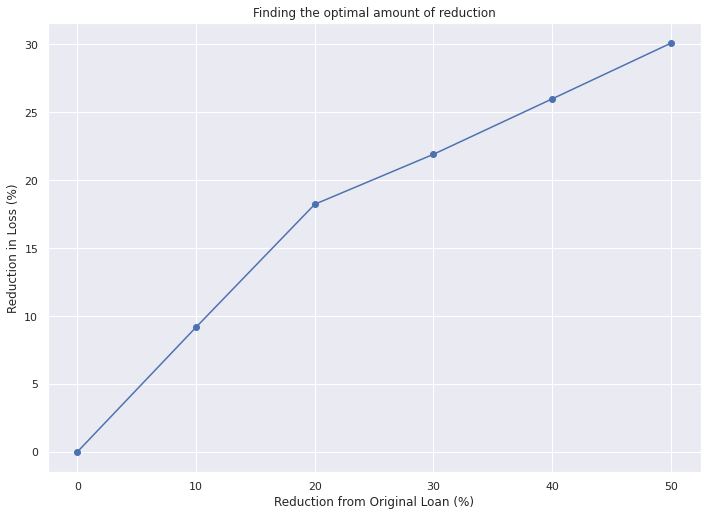

In [ ]:
plt.plot(creditReduction,pctLoss)
plt.scatter(creditReduction,pctLoss)
plt.xlabel('Reduction from Original Loan (%)')
plt.ylabel('Reduction in Loss (%)')
plt.title('Finding the optimal amount of reduction')
plt.show()

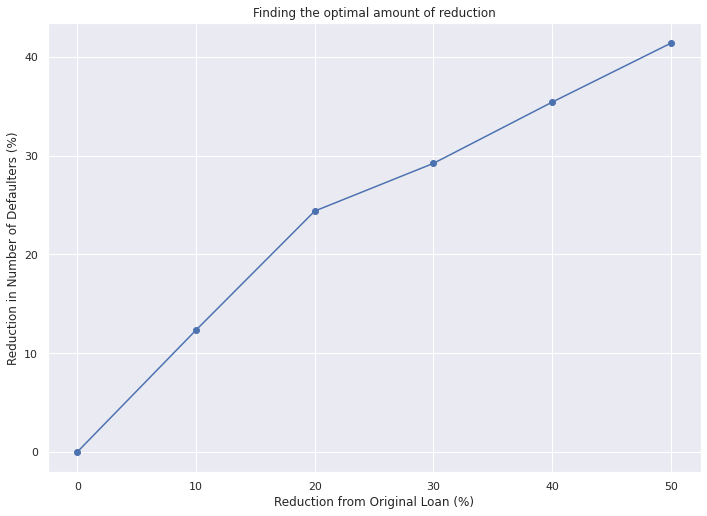

In [ ]:
pctDefaulters = [0, 12.34, 24.39, 29.22, 35.42, 41.39]

plt.plot(creditReduction,pctDefaulters)
plt.scatter(creditReduction,pctDefaulters)
plt.xlabel('Reduction from Original Loan (%)')
plt.ylabel('Reduction in Number of Defaulters (%)')
plt.title('Finding the optimal amount of reduction')
plt.show()

From the above two diagrams, we see that the decrease in loss and number of defaulters increases as we decrease the loan amount.

However, as a bank, we want to match the loan amount requested as much as possible since it is unlikely a person would take up a loan if the loan provided is only 50% (or less than 50%) of what he initially requested.

In the plots above, we see that from reducing the loan by 20% to reducing the loan by 30%, the slope of the both plots is less steep than before, indicating reducing the loan amount by 10% will only result in a smaller reduction than before.

Hence, we will reduce the loans of the predicted defaulters by 20%. In other words, we will only loan 80% the amount they initially requested.

###**Reducing the Credit Loan Amount by 20%**

In [ ]:
default3 = default2.copy()

In [ ]:
default2['AMT_CREDIT'] = default2['AMT_CREDIT']*0.8

In [ ]:
default2['Credit_Category'] = pd.cut(default2.AMT_CREDIT, bins= [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 4.050000e+06],
                              labels= ["0-100k", "100-200k", "200-300k", "300-400k", "400-500k", "500-600k", "600-700k", "700-800k", "800-900k","900-1 million", "Above 1 million"])
default2.drop(['AMT_CREDIT'], axis=1, inplace=True) 

In [ ]:
default2['CODE_GENDER'] = default2['CODE_GENDER'].astype('category')
de1 = dict(zip(default2['CODE_GENDER'], default2['CODE_GENDER'].cat.codes))
default2['CODE_GENDER'] = default2['CODE_GENDER'].map(de1)
print("CODE_GENDER Category Codes")
print(de1)

default2['NAME_INCOME_TYPE'] = default2['NAME_INCOME_TYPE'].astype('category')
de2 = dict(zip(default2['NAME_INCOME_TYPE'], default2['NAME_INCOME_TYPE'].cat.codes))
default2['NAME_INCOME_TYPE'] = default2['NAME_INCOME_TYPE'].map(de2)
print("NAME_INCOME_TYPE Category Codes")
print(de2)

default2['NAME_EDUCATION_TYPE'] = default2['NAME_EDUCATION_TYPE'].astype('category')
de3 = dict(zip(default2['NAME_EDUCATION_TYPE'], default2['NAME_EDUCATION_TYPE'].cat.codes))
default2['NAME_EDUCATION_TYPE'] = default2['NAME_EDUCATION_TYPE'].map(de3)
print("NAME_EDUCATION_TYPE Category Codes")
print(de3)

default2['NAME_FAMILY_STATUS'] = default2['NAME_FAMILY_STATUS'].astype('category')
de4 = dict(zip(default2['NAME_FAMILY_STATUS'], default2['NAME_FAMILY_STATUS'].cat.codes))
default2['NAME_FAMILY_STATUS'] = default2['NAME_FAMILY_STATUS'].map(de4)
print("NAME_FAMILY_STATUS Category Codes")
print(de4)

default2['ORGANIZATION_TYPE'] = default2['ORGANIZATION_TYPE'].astype('category')
de5 = dict(zip(default2['ORGANIZATION_TYPE'], default2['ORGANIZATION_TYPE'].cat.codes))
default2['ORGANIZATION_TYPE'] = default2['ORGANIZATION_TYPE'].map(de5)
print("ORGANIZATION_TYPE Category Codes")
print(de5)

default2['Age_Category'] = default2['Age_Category'].astype('category')
de6= dict(zip(default2['Age_Category'], default2['Age_Category'].cat.codes))
default2['Age_Category'] = default2['Age_Category'].map(de6)
print("Age_Category Category Codes")
print(de6)

default2['Employment'] = default2['Employment'].astype('category')
de7= dict(zip(default2['Employment'], default2['Employment'].cat.codes))
default2['Employment'] = default2['Employment'].map(de7)
print("Employment Category Codes")
print(de7)


default2['Credit_Category'] = default2['Credit_Category'].astype('category')
de8= dict(zip(default2['Credit_Category'], default2['Credit_Category'].cat.codes))
default2['Credit_Category'] = default2['Credit_Category'].map(de8)
print("Credit_Category Codes")
print(de8)

CODE_GENDER Category Codes
{1: 1, 0: 0}
NAME_INCOME_TYPE Category Codes
{7: 5, 1: 0, 3: 2, 4: 3, 6: 4, 2: 1}
NAME_EDUCATION_TYPE Category Codes
{4: 4, 1: 1, 3: 3, 2: 2, 0: 0}
NAME_FAMILY_STATUS Category Codes
{3: 3, 1: 1, 0: 0, 2: 2, 5: 4}
ORGANIZATION_TYPE Category Codes
{5: 5, 7: 7, 42: 42, 47: 47, 20: 20, 57: 56, 26: 26, 30: 30, 33: 33, 53: 52, 9: 9, 3: 3, 51: 50, 13: 13, 17: 17, 39: 39, 41: 41, 28: 28, 43: 43, 16: 16, 11: 11, 35: 35, 34: 34, 40: 40, 31: 31, 54: 53, 2: 2, 4: 4, 14: 14, 55: 54, 38: 38, 44: 44, 1: 1, 24: 24, 19: 19, 0: 0, 21: 21, 32: 32, 18: 18, 46: 46, 27: 27, 12: 12, 36: 36, 45: 45, 37: 37, 10: 10, 22: 22, 52: 51, 15: 15, 56: 55, 50: 49, 8: 8, 6: 6, 25: 25, 29: 29, 49: 48, 23: 23}
Age_Category Category Codes
{'25 to 35': 0, '36 to 45': 1, 'Below 25': 4, '46 to 55': 2, 'Above 55': 3}
Employment Category Codes
{'10 or Less': 1, 'Unemployed': 4, '10 - 20': 0, '20 - 30': 2, 'More than 30': 3}
Credit_Category Codes
{'300-400k': 3, '400-500k': 4, '200-300k': 2}


In [ ]:
X_default2 = default2[sig_var]
y_default2 = default2['TARGET']

In [ ]:
X_default2['CODE_GENDER'] = X_default2['CODE_GENDER'].astype(int)
X_default2['NAME_INCOME_TYPE'] = X_default2['NAME_INCOME_TYPE'].astype(int)
X_default2['NAME_FAMILY_STATUS'] = X_default2['NAME_FAMILY_STATUS'].astype(int)
X_default2['ORGANIZATION_TYPE'] = X_default2['ORGANIZATION_TYPE'].astype(int)
X_default2['Age_Category'] = X_default2['Age_Category'].astype(int)
X_default2['Credit_Category'] = X_default2['Credit_Category'].astype(int)
X_default2['NAME_EDUCATION_TYPE'] = X_default2['NAME_EDUCATION_TYPE'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
X_default2 = X_default2.values

In [ ]:
p = xgb.predict(X_default2)
d2 = sum(p)
fin_debit = default3[p==1]
fin_debit_amt = sum(fin_debit['AMT_CREDIT'])

print(f'After the reduction in loan, there are a total of {d2} defaulters with a total loss of $' + '%0.2f' %fin_debit_amt + '.')

After the reduction in loan, there are a total of 5066 defaulters with a total loss of $2313877014.00.


In [ ]:
amt = init_debit_amt - fin_debit_amt
pct = round(amt / init_debit_amt * 73.54, 2)
dpct = round((d1-d2)/d1 * 100, 2)

print('By reducing the loan amount to 80% of the original amount, we managed to reduce the loss by $' + '%0.2f' % amt + f' (or {pct}%).')
print(f'The number of defaulters decreases by {dpct}%')

By reducing the loan amount to 80% of the original amount, we managed to reduce the loss by $762597495.00 (or 18.23%).
The number of defaulters decreases by 24.39%
